# Laboratorio 5 - Data Science Universidad del Valle de Guatemala
María Marta Ramírez Gil 21342
Gustavo Andrés Gonzalez 21438 

------------------------------------------------------------------------------

Importaciones  

In [3]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cargar la data

In [4]:
data = pd.read_csv('train.csv')

# EDA

In [9]:
# Mostrar las primeras filas del dataset
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Chequear si hay valores nulos
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
# Eliminar valores nulos
data = data.dropna()

# Chequear si quedan valores nulos
data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [17]:
# Estadiscas descriptivas del dataset
print("info del dataset:")
data.info()

info del dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


In [20]:
# Cantidad de columnas
print("Cantidad de columnas:")
print(len(data.columns))
print()

print("Nombre de las columnas:")
print(data.columns)
print()

# Cantidad de filas
print("Cantidad de filas:")
print(data.shape)
print()

# Tipos de datos por columna
print("Tipos de datos por columna:")
data.dtypes

Cantidad de columnas:
5

Nombre de las columnas:
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

Cantidad de filas:
(5080, 5)

Tipos de datos por columna:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Limpiar y Preprocesamiento de la data

In [26]:
data_copy = data.copy()  # Copia del dataset para mejor manejo de los datos

# Convertir texto a minúsculas
data_copy['text'] = data_copy['text'].str.lower()

# Quitar URL's
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# Quitar puntuación
data_copy['text'] = data_copy['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Quitar stopwords
stop = set(stopwords.words('english'))
data_copy['text'] = data_copy['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Quitar números
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'\d+', '', x))

# Eliminar todas las posibles variantes de 'û'
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'[ûÛ]', '', x))

# Mostrar las primeras filas del dataset
data_copy.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesale markets ablaze,1
32,49,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt,0
33,50,ablaze,AFRICA,africanbaze breaking newsnigeria flag set abla...,1
34,52,ablaze,"Philadelphia, PA",crying set ablaze,0
35,53,ablaze,"London, UK",plus side look sky last night ablaze,0


## Word Frequency Analysis

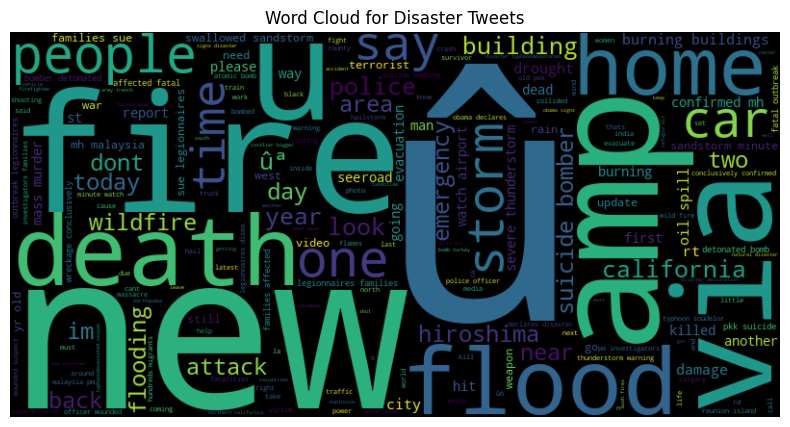

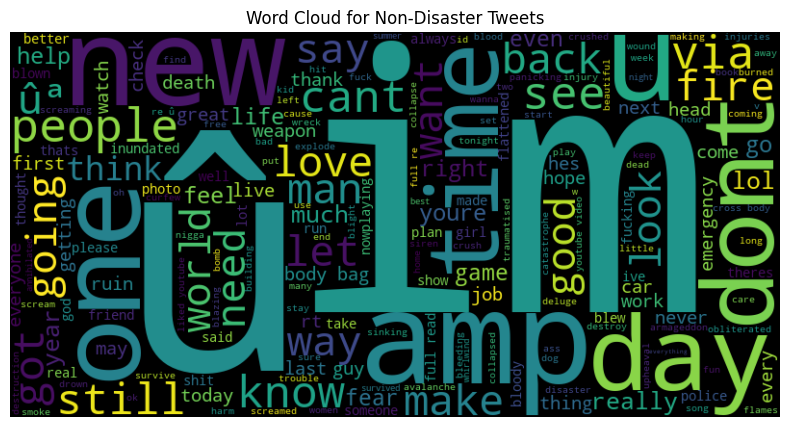

In [27]:
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Cantidad de tweets de desastres
disaster_words = ' '.join(disaster_tweets['text'])
non_disaster_words = ' '.join(non_disaster_tweets['text'])

# Generar wordclouds
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(disaster_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Disaster Tweets')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(non_disaster_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-Disaster Tweets')
plt.axis('off')
plt.show()

## Entrenamiento del Modelo

In [28]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

# Crear el modelo
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Evaluacion del Modelo